# Predicting A Garment Factory's Productivity #
### By Justin Wong, Longfei Guan, Anirudh Duggal ###

#### Adapted with permission from STAT 301 Project by: Justin Wong, Kevin Yu, Zhuoran (Serena) Feng, Fiona Chang ####

## 1. Summary ##
In this project, we perform a data analysis to determine the factors that impact the predict the productivity of a garment factory. Using forward selection and LASSO, we compare different models and determine which factors are the best in explaining relationships between the factors and the actual productivity of the garment factory. Furthermore, we discuss the implications of our results, the limitations of the project, and propose future  questions that can be asked based on our project.

## 2. Introduction ##
The trillion-dollar garment industry is largely fueled by the production and performance of employees that work in manufacturing companies as a labor-intensive, low-skilled industry (Hamja et al., 2019). As the industry is driven by ever-changing consumer demands and fashion trends, the need for manual processes is inevitable. Through statistical inference, we seek to dig deeper into the relationship between important attributes of the garment manufacturing process and its employees’ productivity in the following question: **What factors affect the productivity of a garment factory?** 

The studies: “Enhancing Efficiency and Productivity of Garment Industry by Using Different Techniques” (Rajput et al., 2018) and “The Effect of Lean on Occupational Health and Safety and Productivity in the Garment Industry” (Hamja et al., 2019) will be utilized to help frame our exploration into this data set and provide useful context of the garment industry.


### Attribute Information ###
The data set we will use, called Productivity Prediction of Garment Employees, is sourced from Kaggle.com and outlines following variables that will guide us in answering our question:
- `date`: Date in MM-DD-YYYY
- `quarter`: A portion of a month, where each month was divided into 4 quarters
- `department`: Associated department
- `day`: Day of the week
- `team`: Associated team number
- `targeted_productivity_set`: Daily target productivity set by authority
- `smv`: Standard Minute Value; allocated time for a task
- `wip`: Work in progress; includes number of unfinished items for products
- `over_time`: amount of overtime by each team (minutes)
- `Incentive`: amount of financial incentive in BDT (Bangladeshi currency)
- `idle_time`: amount of time where production was interrupted
- `Idle_men`: number of workers idle due to interrupted production
- `no_of_style_changes`: number of style changes
- `no_of_workers`: number of workers in given team
- `actual_productivity`: actual % of productivity delivered

From this list, `date` and `team` were excluded in our analysis as they are identifiers for the observation, hence not the interest for our research question.

# 3. Methods and Results #

## 3.1 Preliminary Results ##

In [1]:
# Load Libraries
suppressPackageStartupMessages({
library(tidyverse)
library(broom)
library(GGally)
library(leaps)
library(glmnet)
    })
source("../src/R/load_data.R")
source("../src/R/clean_data.R")
source("../src/R/create_boxplot.R")
source("../src/R/train_test_split.R")

In [2]:
# Download file from online source
data<-load_data("https://7e6cd356-86ad-4874-abc7-3a69bbbc39e6.filesusr.com/ugd/c5a545_c1b17c070c984dfcb14cf1c3bb0b6e67.csv?dn=garments_worker_productivity.csv")
cat("Table 3.1: Initial Dataset")
head(data,3)

Table 3.1: Initial Dataset

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108,7080,98,0,0,0,59.0,0.9407254
2,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NA,960,0,0,0,0,8.0,0.8865000
3,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968,3660,50,0,0,0,30.5,0.8005705


In [3]:
# Cleaning the dataset
data.filtered <- 
    clean_data(data, c("date", "team")) %>% # removing variables not used (date and team)
    mutate(wip = ifelse((is.na(wip)), 0, wip)) %>% 
    mutate(department = ifelse((department == "finishing "), "finishing", department)) %>% # fixing typos for "finishing"
    mutate(department = ifelse((department == "sweing"), "sewing", department)) %>% # fixing typos for "sewing"
    mutate(department = as.factor(department)) %>% # change department variable to a factor
    mutate(day = if_else(day %in% c("Monday", "Tuesday", "Wednesday", "Thursday"), "Weekday", "Weekend")) %>% # editing day variable
    mutate(half = if_else(quarter %in% c("Quarter1", "Quarter2"), "Half1", "Half2"))  %>%  # creating quarter variable using quarter variable
    clean_data(., "quarter") %>% # removing quarter variable
    mutate(day = as.factor(day)) %>% # change day variable to a factor
    mutate(half = as.factor(half)) # change half variable to a factor
cat("Table 3.2: Modified Dataset")
head(data.filtered,3)

Table 3.2: Modified Dataset

,department,day,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,half
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<dbl>,<fct>
1,sewing,Weekday,0.80,26.16,1108,7080,98,0,0,0,59.0,0.9407254,Half1
2,finishing,Weekday,0.75,3.94,0,960,0,0,0,0,8.0,0.8865000,Half1
3,sewing,Weekday,0.80,11.41,968,3660,50,0,0,0,30.5,0.8005705,Half1


Both the categorical variables `day` and `quarter` were edited becasue they have more than two levels, which leads to difficulties in conducting forward selection. Based on this, `day` was changed into two levels: Weekday and Weekend. Similarilily, `quarter` was used to create the variable `half` with two levels.

Figure 3.1: ggpairs Plot

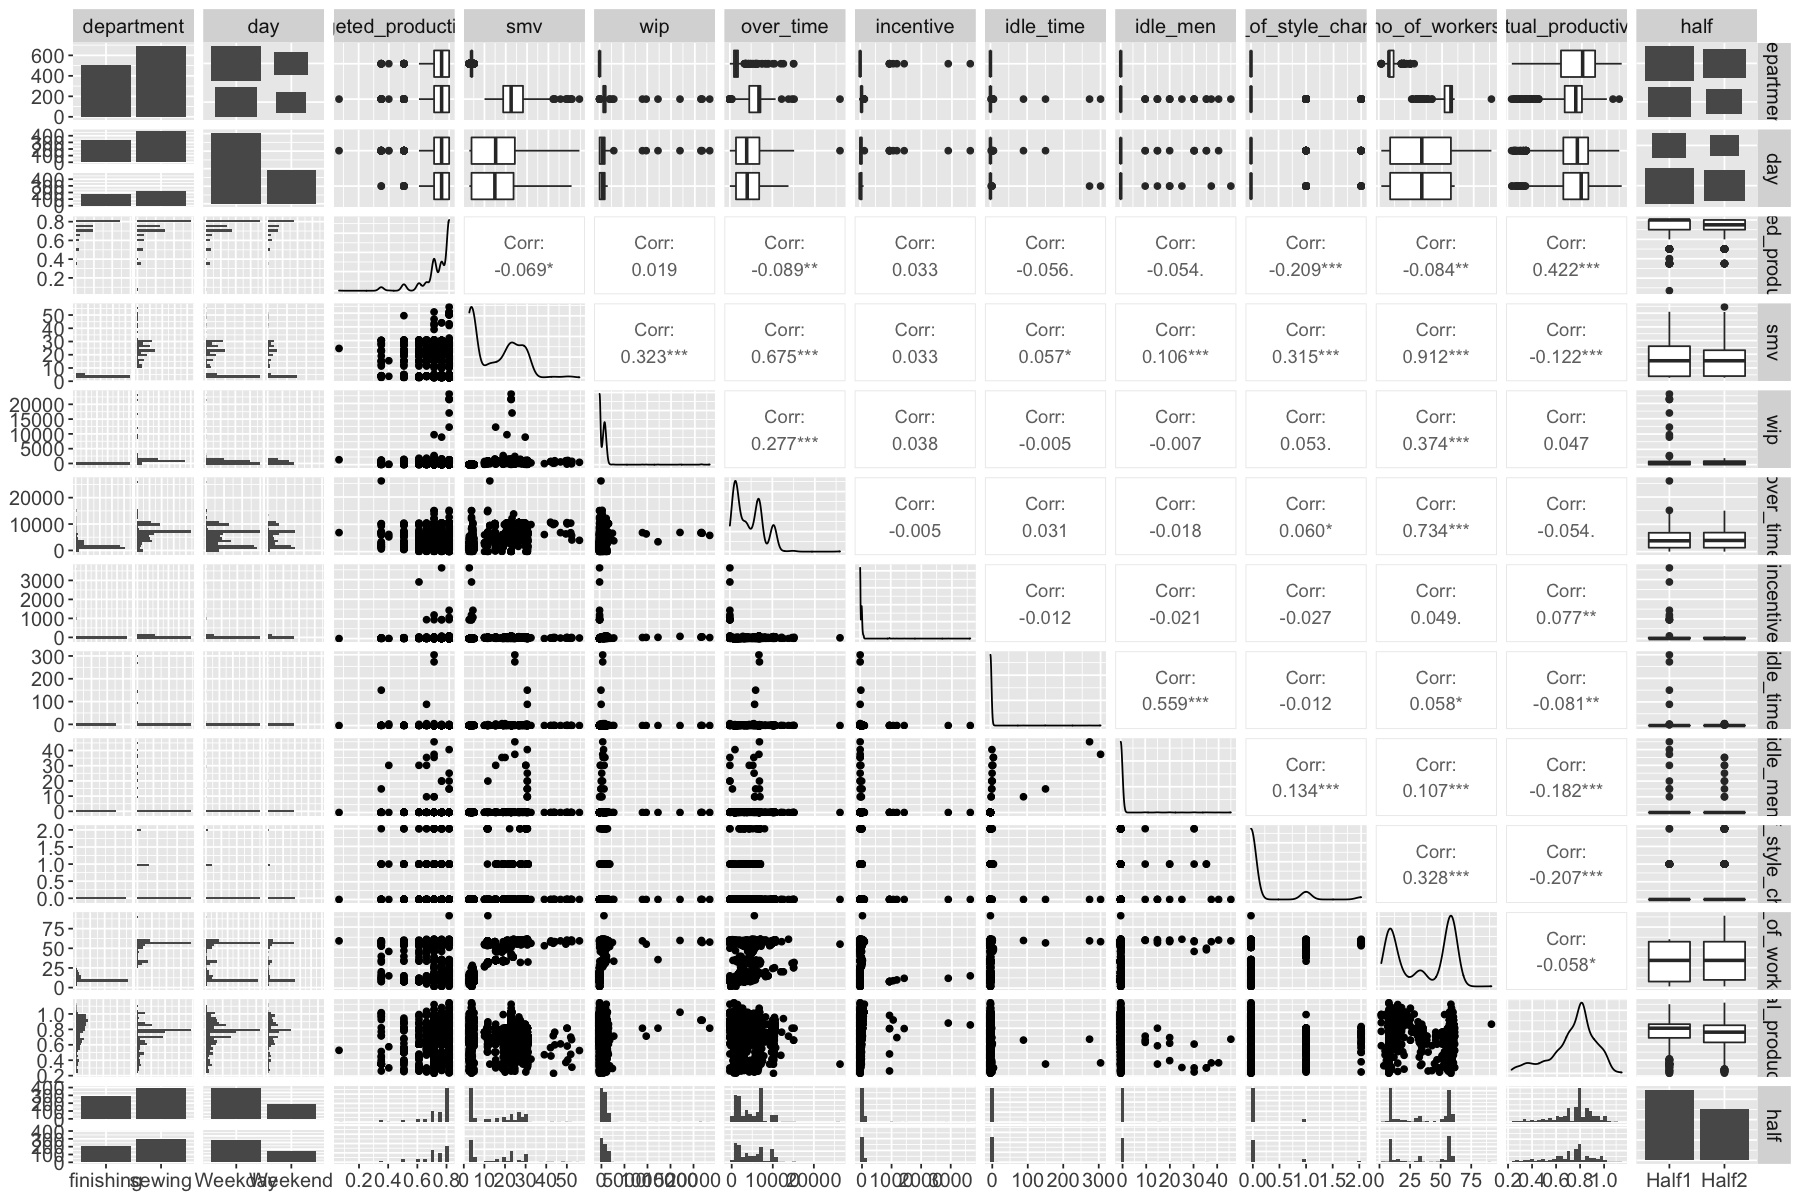

In [4]:
# Complete ggpairs for all data
options(repr.plot.width = 15, repr.plot.height = 10) 

pair_plots <-ggpairs(data.filtered) +
  theme(
    text = element_text(size = 15),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  )
cat("Figure 3.1: ggpairs Plot")
suppressWarnings(suppressMessages(print(pair_plots)))

From this plot, we can analyze the correlation values between the variables that we are using in our analysis. Based on the correlation values, there appears to be correlation between input variables, which will be addressed later in the analysis. Variables with relatively high correlations (over 0.65) include `no_of_workers` and `smv`, `no_of_workers` and `over_time`, and `over_time` and `smv`.

The high correlation indicates that the dataset has an issue of multicollinearity. To address this, the variable with the (`no_of_workers`) will be removed from our analysis.

In [5]:
# Remove no_of_workers from data
data.filtered <- clean_data(data.filtered, "no_of_workers")

Figure 3.2: Actual Productivity by Day of the Week Boxplot

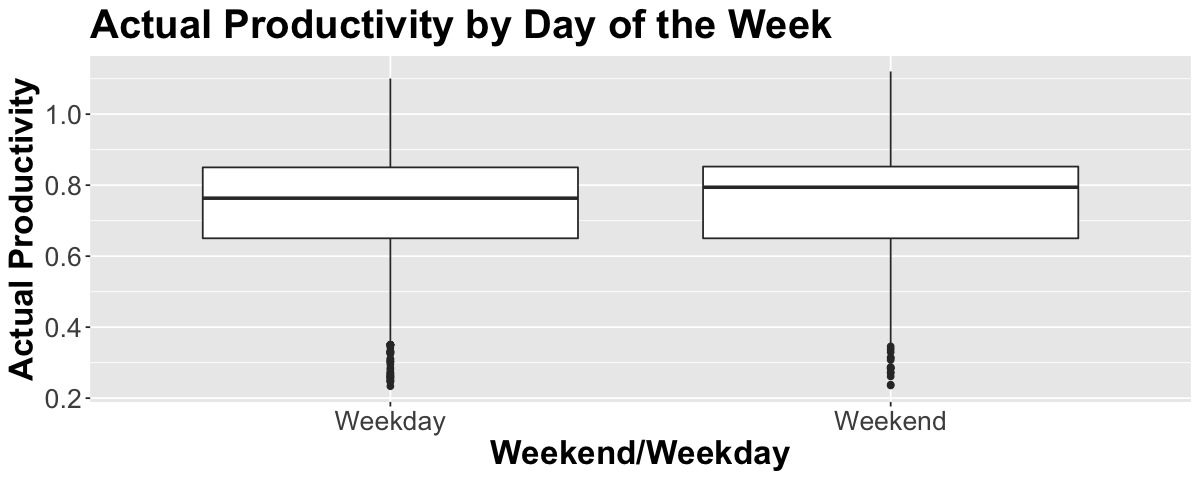

Figure 3.3: Actual Productivity by Half Boxplot

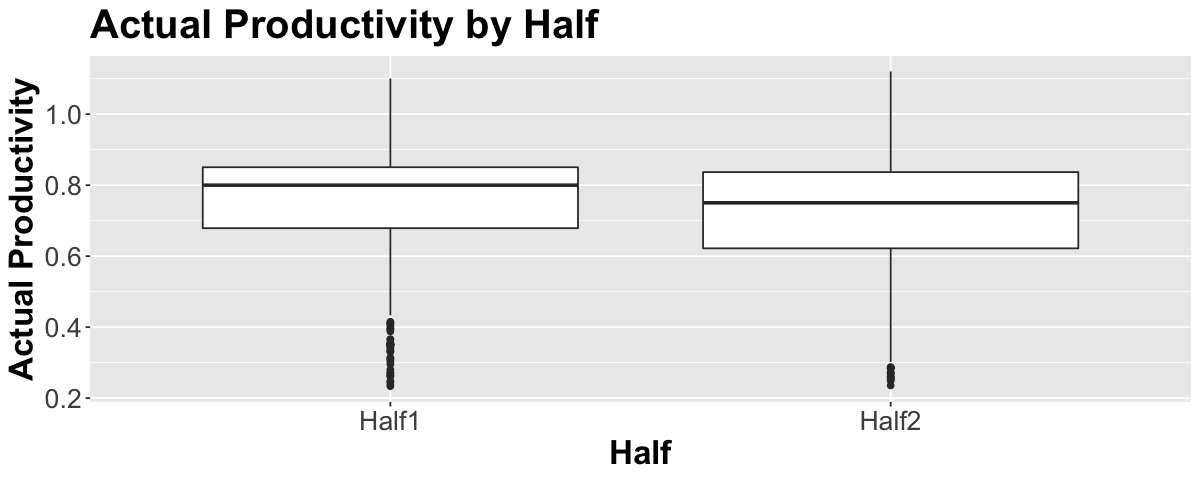

Figure 3.4: Actual Productivity of Departments Boxplot

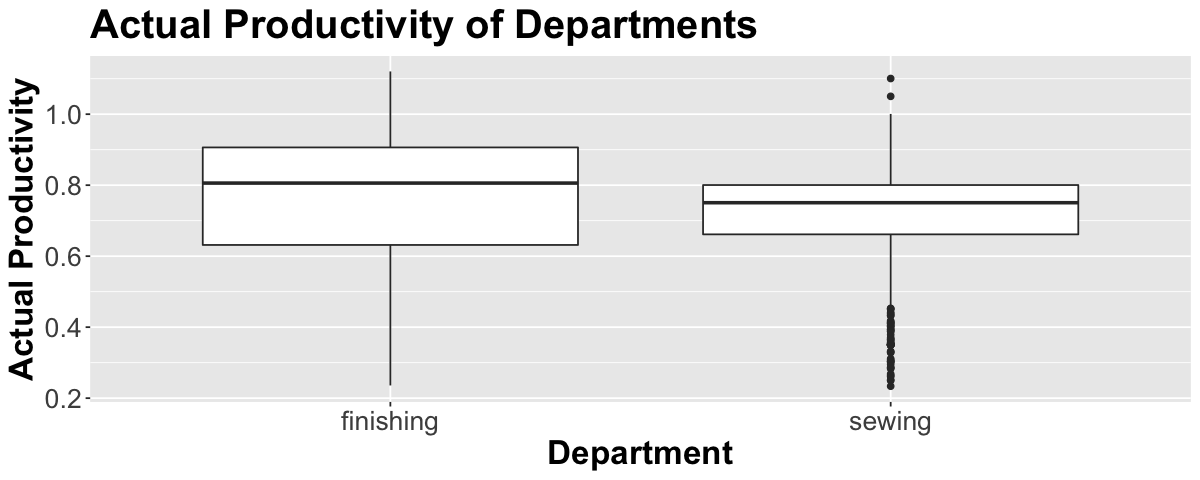

In [6]:
options(repr.plot.width = 10, repr.plot.height = 4)

# Boxplot comparing the actual productivity of different day to analyze mean + variance
day_boxplot <- create_boxplot(data.filtered, data.filtered$day, 
                              data.filtered$actual_productivity, 
                              "Actual Productivity by Day of the Week", 
                              "Weekend/Weekday", "Actual Productivity")
cat("Figure 3.2: Actual Productivity by Day of the Week Boxplot")
day_boxplot


# Boxplot to compare the actual productivity of different halves 
half_boxplot <- create_boxplot(data.filtered, data.filtered$half, 
                               data.filtered$actual_productivity, 
                              "Actual Productivity by Half", 
                              "Half", "Actual Productivity")
half_boxplot
cat("Figure 3.3: Actual Productivity by Half Boxplot")

# Boxplot to compare the actual productivity of different departments.
department_boxplot <- create_boxplot(data.filtered, data.filtered$department, 
                                     data.filtered$actual_productivity, 
                                  "Actual Productivity of Departments", 
                                  "Department", "Actual Productivity")
department_boxplot
cat("Figure 3.4: Actual Productivity of Departments Boxplot")


The above boxplots show the medians and variances of the discrete factors of interest. Since the above plots show that there are differences in the medians and variances of the factors of interest, it is justified to keep these factors in our analysis for future investigation.



Figure 3.5: Distribution of Actual Productivity

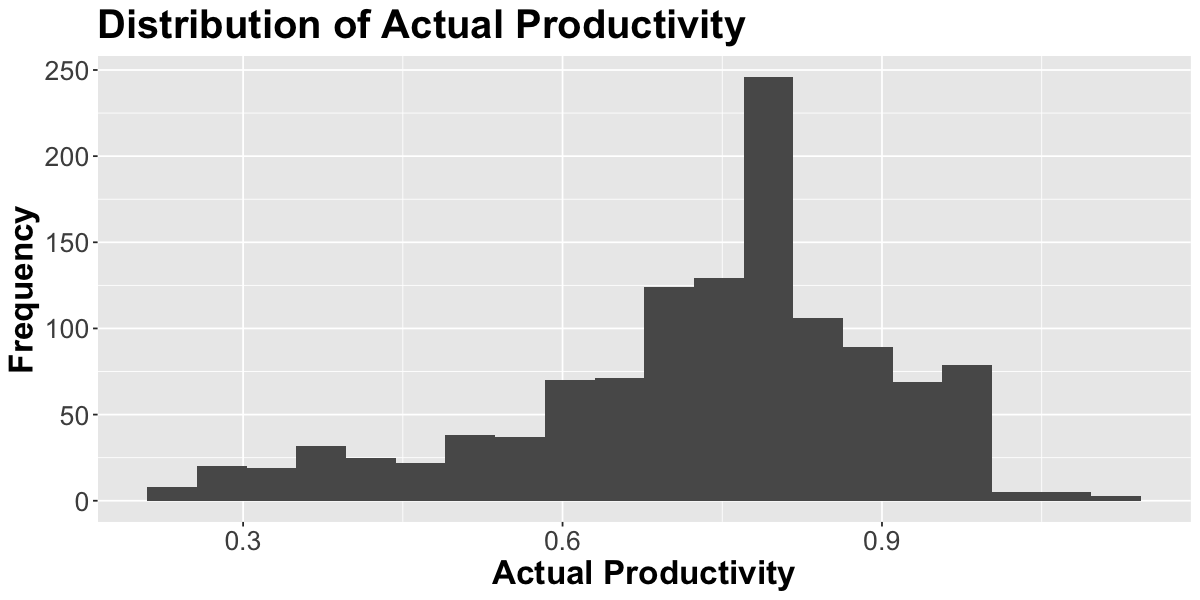

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)

# Histogram for Actual Productivity
actual_productivity_distribution <- data.filtered %>%
                                      ggplot(aes(x = actual_productivity)) +
                                      geom_histogram(bins = 20) +
                                    ggtitle("Distribution of Actual Productivity")+
                                      labs(x = "Actual Productivity") +
                                      labs(y = "Frequency")+ theme(
                                        text = element_text(size = 20),
                                        plot.title = element_text(face = "bold"),
                                        axis.title = element_text(face = "bold") )
cat("Figure 3.5: Distribution of Actual Productivity")
actual_productivity_distribution

Since, the distribution of the actual productivity doesn't seem to have a normal distribution and is slightly left-skewed, an assumption of normality is likely needed in our analysis.

Figure 3.5: Q-Q Plot of Actual Productivity

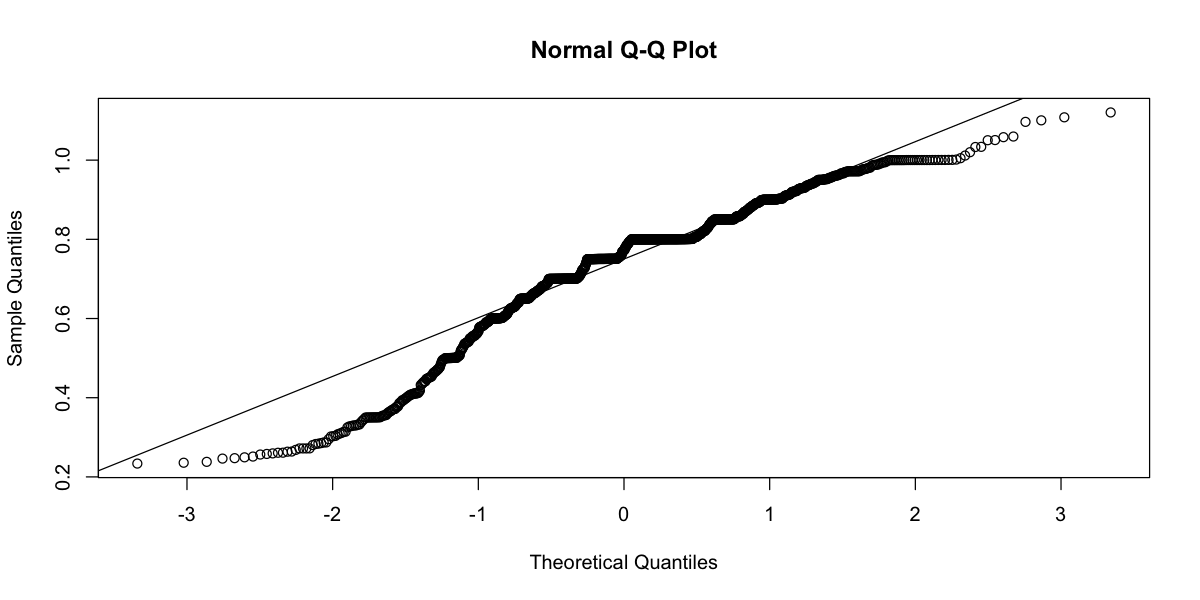

In [8]:
# Checking the normalitiy of the actual_productivity (response variable)
cat("Figure 3.5: Q-Q Plot of Actual Productivity")
qqnorm(data.filtered$actual_productivity)
qqline(data.filtered$actual_productivity)

The above Q-Q plot was used to determine whether a normality assumption on our response variable is valid, since it is an assumption required for tests used later on. There appears to be tails on both ends, which suggests a left-skewness of the data. Unfortunately, while we have tried different transformations of the data, it did not improve the skewness of this Q-Q plot. So based on what we have learned in this class, we will have to assume normality of the data even though it is a major stretch.

In [9]:
# summary table of actual_productivity for different halves and departments
summary_table_1 <- data.filtered %>%
                   group_by(half, department) %>%
                   summarise(count = n(),
                             mean = mean(actual_productivity),
                             median = median(actual_productivity), 
                             min = min(actual_productivity),
                             max = max(actual_productivity),
                             sd = sd(actual_productivity), 
                            .groups = 'keep'
                            )
cat("Table 3.3: Summary of Actual Productivity for Halves and Departments")
summary_table_1

Table 3.3: Summary of Actual Productivity for Halves and Departments

half,department,count,mean,median,min,max,sd
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Half1,finishing,296,0.7616317,0.8096023,0.2380417,1.096633,0.1823244
Half1,sewing,399,0.7374970,0.7999632,0.2337055,1.100484,0.1522631
Half2,finishing,210,0.7407145,0.7862321,0.2357955,1.120437,0.2159050
Half2,sewing,292,0.7008552,0.7500680,0.2494167,1.000457,0.1559532


This table provides relevant summaries of our data, split into different quarters and departments. Overall, the data seems to be relatively consistent, with a few things to note:

- The relative means and medians are fairly consistent throughout the different departments and halves.
- The standard deviation for the finishing department is slightly larger than the sewing department.

## 3.2 Methods: Plan ##
The data set used is trustworthy and reliable since multiple published academic papers used this data set (Imran et al (2019), Rahim et al (2021)). 

Using the data set, we plan to analyze what factors are the most important in productivity. Linear regression will be used to determine the best inference model for the actual productivity of the factory. Using forward selection and LASSO, we plan to compare different models and determine which factors are the best in explaining relationships between the factors and the actual productivity of the garment factory. Additionally, we plan to test our optimal inference model’s performance by splitting the data into training and testing and comparing the corresponding adjusted $R^2$ values with the full model.

We expect that factors such as number of members on the team and targeted productivity may have a higher association with actual productivity. Thus, we expect these factors to be present in the best model for explaining the relationship with the actual productivity.

The results from this report could provide insights to companies in the garment manufacturing sector. Having knowledge on what factors may increase productivity is crucial for any successful business.

## 3.3 Results ##

### 3.3.1 Generating the Model with Forward Selection ###

In [10]:
# Split the data into two datasets: training dataset (75%) and testing dataset (25%)
set.seed(20221127)

data.filtered$ID <- 1:nrow(data.filtered)
new_data<-train_test_split(data.filtered, 0.75, "ID")
training_data<-as.data.frame(new_data[1])
testing_data<-as.data.frame(new_data[2])

#Remove ID varaible
training_data<-clean_data(training_data, "ID")
testing_data<-clean_data(testing_data, "ID")

In [11]:
# Use forward selection to select models with different number of input variables
model_forward_sel <- regsubsets(
  x = actual_productivity ~ .,
  nvmax = 12,
  data = training_data,
  method = "forward")

model_forward_summary <- summary(model_forward_sel)

In [12]:
# store and examine different evaluation metrics contained in model_forward_summary
model_forward_summary_df <- data.frame(
  n_input_variables = 1:11,
  RSQ = model_forward_summary$rsq,
  RSS = model_forward_summary$rss,
  ADJ.R2 = model_forward_summary$adjr2
)
cat("Table 3.5: Evaluation Metrics for Forward Selection")
model_forward_summary_df

Table 3.5: Evaluation Metrics for Forward Selection

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.1945884,21.49255,0.1936885
2,0.2164887,20.90814,0.2147359
3,0.2281308,20.59747,0.2255377
4,0.2310129,20.52056,0.2275645
5,0.2337486,20.44755,0.2294487
6,0.2377994,20.33946,0.2326610
7,0.2384121,20.32311,0.2324154
8,0.2389621,20.30843,0.2321059
9,0.2392325,20.30121,0.2315134


Adjusted $R^2$ was chosen as the metric used for model selection because it is best suited for our inference model. It compensates for the reduction of the RSS of a larger model making it a more suitable metric than $R^2$.

As shown by the table above, the model with 6 input variables has the highest adj $R^2$ (0.23266), thus this model is chosen as the optimal model. However, its adjusted $R^2$ value is not relatively higher than many of the other models, suggesting that the model may be only slightly better than the others. The selected model will be compared with the full model to test this observation.


The variables selected in the model with 6 input variables  were: `targeted_productivity`, `smv`, `wip`, `incentive`, `idle_men`, and `no_of_style_change`. 

In [13]:
# Find Adj R^2 for chosen optimal model
cat("Table 3.6: Summary Table for Selected Model")
model_selected_1 <- lm(actual_productivity ~ targeted_productivity +
                    smv + wip + incentive + idle_men + no_of_style_change, 
                    data = training_data)
model_selected_summary_1 <- tidy(model_selected_1)
model_selected_summary_1


adj_r_squared_1 <- summary(model_selected_1)$adj.r.squared 
cat("Adjusted R^2 for Selected Model:")
adj_r_squared_1

Table 3.6: Summary Table for Selected Model

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.425582e-01,3.937798e-02,6.159742,1.102206e-09
targeted_productivity,6.992923e-01,5.202801e-02,13.440690,1.247899e-37
smv,-1.241413e-03,5.187792e-04,-2.392951,1.691987e-02
wip,7.646482e-06,3.515867e-06,2.174850,2.990408e-02
incentive,6.773159e-05,3.571330e-05,1.896537,5.821268e-02
idle_men,-6.658320e-03,1.549864e-03,-4.296067,1.929960e-05
no_of_style_change,-3.696440e-02,1.271463e-02,-2.907235,3.736943e-03


Adjusted R^2 for Selected Model:

[1] 0.232661

Figure 3.7: Residuals and Q-Q Plot of Selected Model

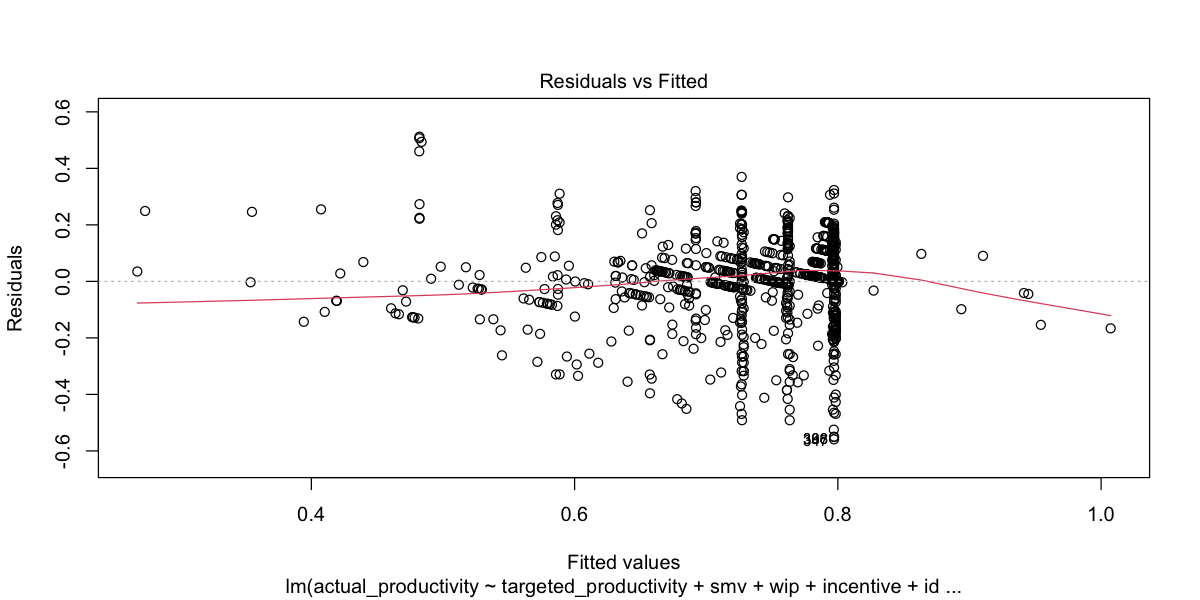

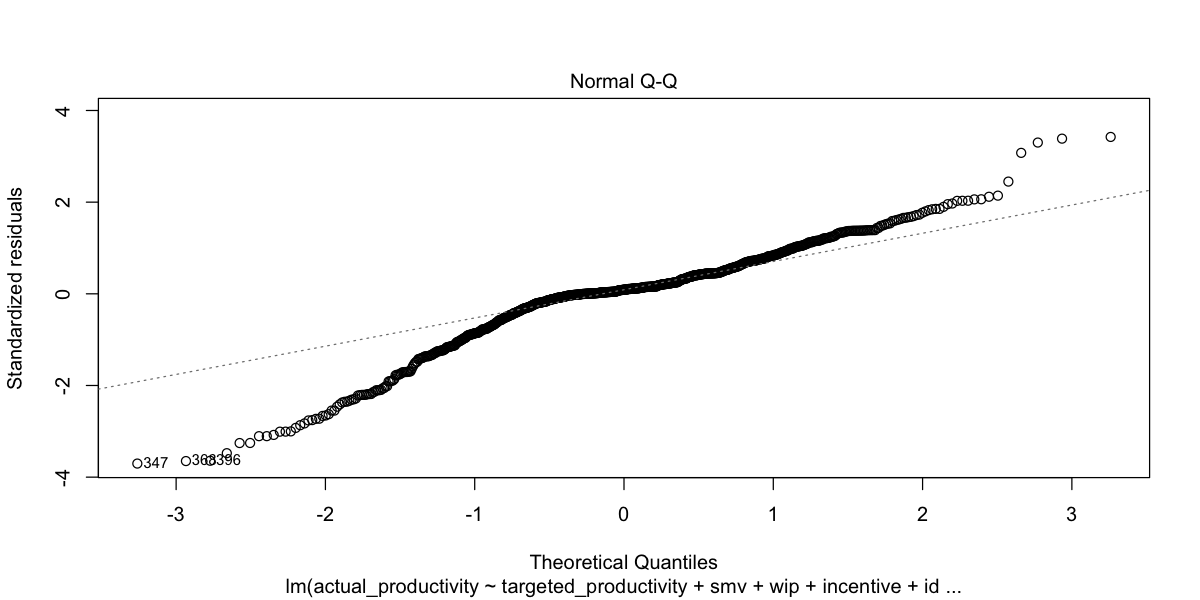

In [14]:
# Checking assumptions of selected model
cat("Figure 3.7: Residuals and Q-Q Plot of Selected Model")
plot(model_selected_1, 1:2)

The residual plot and the Q-Q plot suggests some violations of assumptions needed for our analysis. The residual plot shows slight heteroskedasticity within our model, which violates our equal variance assumption, and the q-q plot suggests a violation in our normality assumption. 

In [15]:
# Find Adj R^2 for chosen full model for future comparison with chosen model
cat("Table 3.7: Summary Table for Full Model")
full_model <- lm(actual_productivity ~ ., data = training_data)
full_model_summary <- tidy(full_model, 0.95, conf.int = TRUE)
full_model_summary

adj_r_squared_full <- summary(full_model)$adj.r.squared 
cat("Adjusted R^2 for Full Model:")
adj_r_squared_full

Table 3.7: Summary Table for Full Model

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.436616e-01,4.076032e-02,5.97791050,3.275007e-09,1.636634e-01,3.236597e-01
departmentsewing,1.695803e-02,2.191951e-02,0.77365008,4.393443e-01,-2.606225e-02,5.997831e-02
dayWeekend,6.135577e-03,1.080100e-02,0.56805629,5.701408e-01,-1.506299e-02,2.733414e-02
targeted_productivity,6.988608e-01,5.268248e-02,13.26552497,9.205911e-37,5.954636e-01,8.022580e-01
smv,-1.877742e-03,9.822025e-04,-1.91176631,5.622886e-02,-3.805459e-03,4.997624e-05
wip,7.060419e-06,3.621374e-06,1.94965190,5.153313e-02,-4.706419e-08,1.416790e-05
over_time,-7.803024e-08,2.139101e-06,-0.03647804,9.709094e-01,-4.276334e-06,4.120273e-06
incentive,6.620842e-05,3.592302e-05,1.84306406,6.565391e-02,-4.295821e-06,1.367127e-04
idle_time,3.560346e-04,4.497165e-04,0.79168672,4.287555e-01,-5.266007e-04,1.238670e-03


Adjusted R^2 for Full Model:

[1] 0.2300469

The adjusted $R^2$ of the selected model (0.2327) is slightly larger than (0.2300) the full model. This further suggests the selected model is not significantly better than the full model. An F-test will be conducted to test this observation.

In [16]:
# F-test for the full model and the selected model 
cat("Table 3.8: F-test for Full and Selected Model")
f_test<-anova(model_selected_1, full_model)
f_test

Table 3.8: F-test for Full and Selected Model

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,890,20.33946,NA,NA,NA,NA
2,885,20.29409,5,0.04536631,0.3956736,0.8519733


Since the p-value is 0.852, at a 5% significance level, there is not enough evidence to reject the null hypothesis that the selected model performs better than the full model.

In [17]:
# Testing Selected Model with Testing Data
cat("Table 3.9: Summary Table for Selected Model with Testing Data")
model_1 <- lm(actual_productivity ~ targeted_productivity +
                    smv + wip + incentive + idle_men + no_of_style_change, ,
              data = testing_data)
model_summary <- tidy(model_1)
model_summary

adj_r_squared <- summary(model_1)$adj.r.squared 
cat("Adjusted R^2 for Selected Model Using Testing Data:")
adj_r_squared

Table 3.9: Summary Table for Selected Model with Testing Data

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.689469e-01,7.881555e-02,3.412359,7.346926e-04
targeted_productivity,6.689556e-01,1.052842e-01,6.353807,8.010743e-10
smv,-1.186452e-03,9.566367e-04,-1.240232,2.158819e-01
wip,7.676183e-06,6.741129e-06,1.138709,2.557548e-01
incentive,5.626808e-05,4.648146e-05,1.210549,2.270439e-01
idle_men,-9.929246e-03,3.033895e-03,-3.272772,1.192444e-03
no_of_style_change,-2.856274e-02,2.437878e-02,-1.171623,2.423002e-01


Adjusted R^2 for Selected Model Using Testing Data:

[1] 0.1702206

The adjusted $R^2$ suggests that about 17% of the adjusted variation in the response is explained by model. This indicates that the model performs fairly poorly. However, since it was the best model according to our analysis it may suggest that further exploration of this topic is needed. Thus, model selection using LASSO is conducted next.

### 3.3.2 Generating the Model with LASSO ###

In [18]:
# split datasets into x matrix and y matrix for training and testing
data_X_train <- training_data %>% select(-"actual_productivity")  %>% data.matrix()
data_Y_train <- training_data %>% select("actual_productivity")  %>% data.matrix()

data_X_test <- testing_data %>% select(-"actual_productivity")  %>% data.matrix()
data_Y_test <- testing_data %>% select("actual_productivity")  %>% data.matrix()

In [19]:
# find an "optimal" value of lambda using the function cv.glmnet()
data_cv_lambda_LASSO <- cv.glmnet(
  x = data_X_train, y = data_Y_train,
  alpha = 1)

Figure 3.9: Lambda Selection by CV with LASSO

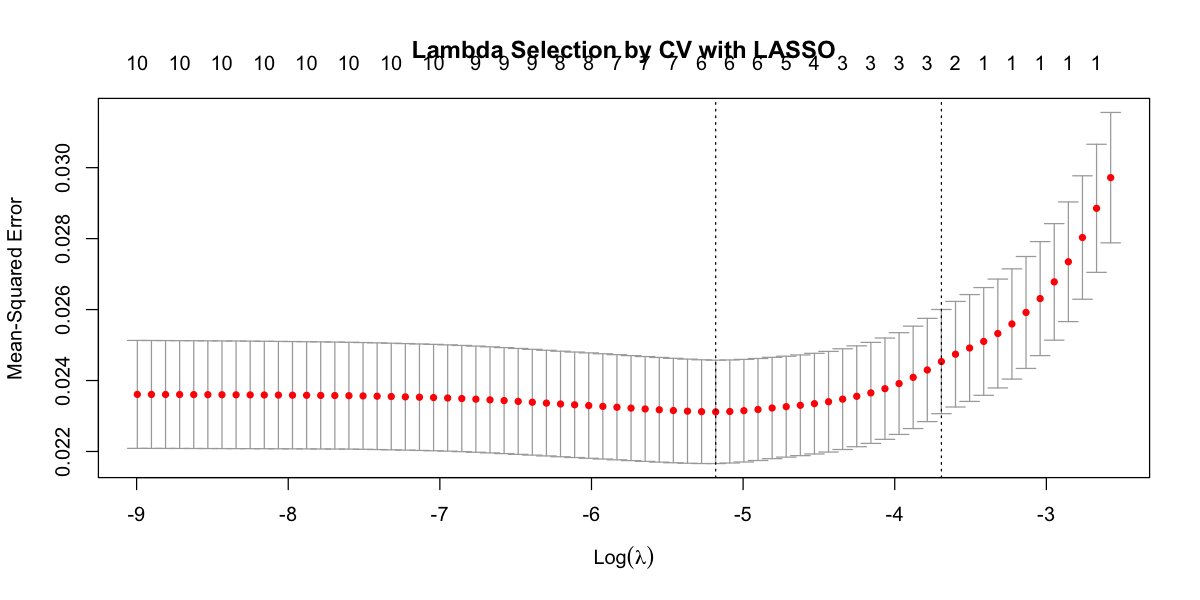

In [20]:
# visualize how the estimated test-MSE changes for different values of lambda
cat("Figure 3.9: Lambda Selection by CV with LASSO")
plot(data_cv_lambda_LASSO, main = "Lambda Selection by CV with LASSO")

# store the lambda value which provide the minimum estimated test-MSE
lambda_min_MSE_LASSO <- round(data_cv_lambda_LASSO$lambda.min, 4)

In [21]:
# build a LASSO model 
data_LASSO_min <- glmnet(
  x = data_X_train, y = data_Y_train,
  alpha = 1,
  lambda = lambda_min_MSE_LASSO
)


In [22]:
# get the selected input variables by the LASSO model
variables_selected_LASSO <- as_tibble(as.matrix(coef(data_LASSO_min)),rownames='covariate') %>%
                              filter(covariate != '(Intercept)' & abs(s0) > 10e-6) %>% 
                              pull(covariate)
#variables_selected_LASSO

The variables selected in the model by LASSO were:  `targeted_productivity`, `smv`, `incentive`, `idle_men`, and `no_of_style_change`. 

In [23]:
# the model selected by LASSO
LASSO_model <- lm(actual_productivity ~ targeted_productivity +
                    smv + incentive + idle_men + no_of_style_change, 
                  data = training_data)

Figure 3.10: Residuals and Q-Q Plot of Model Selected by LASSO

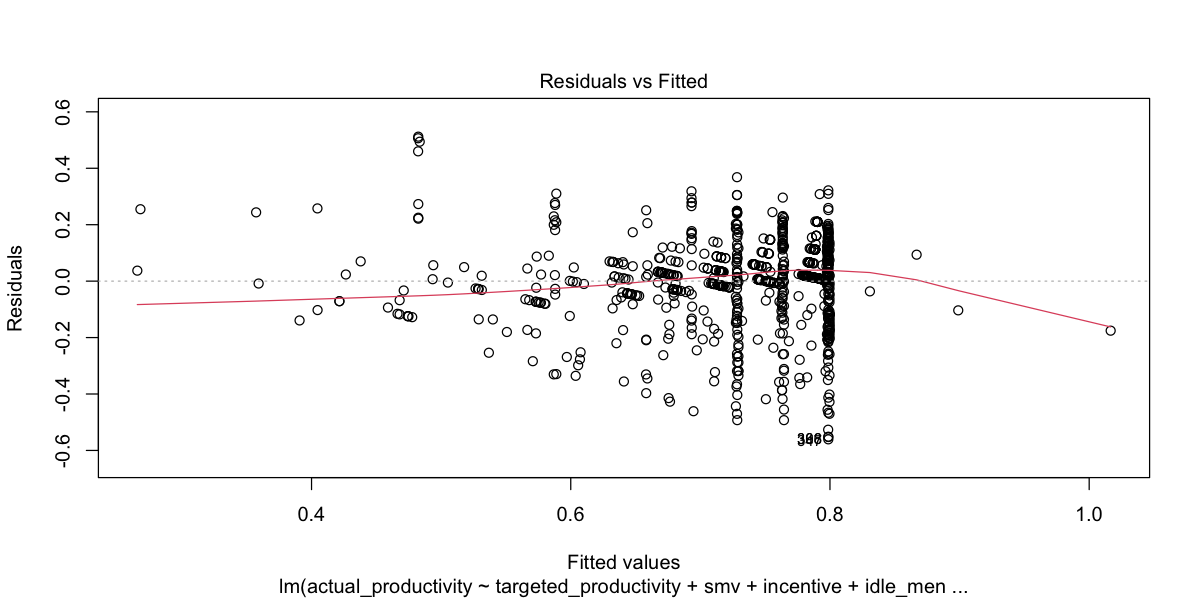

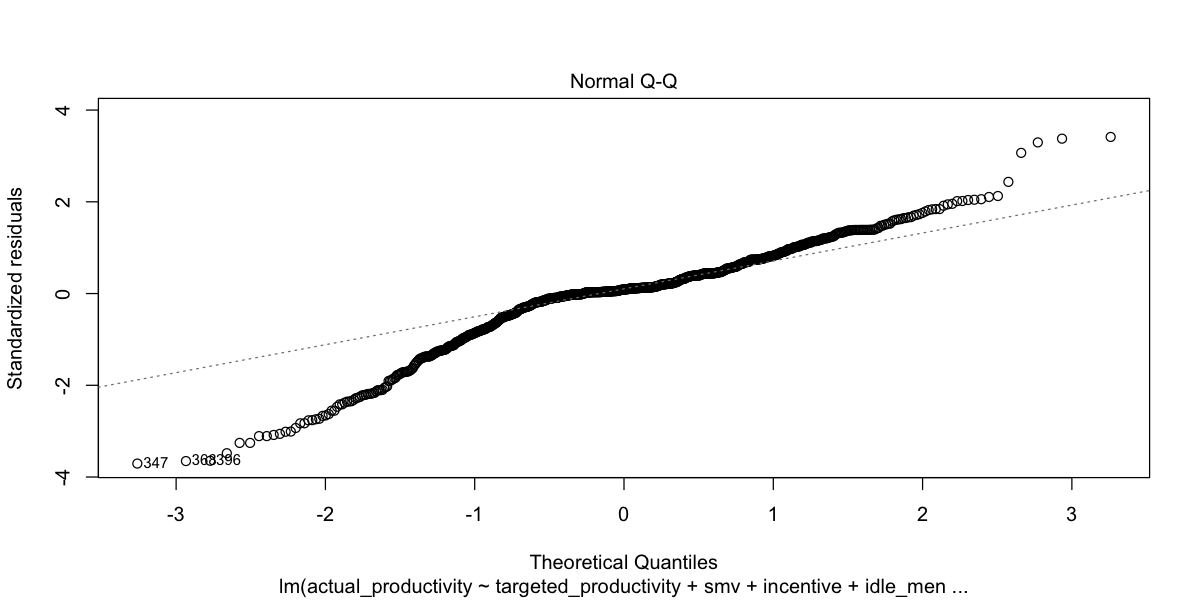

In [24]:
# Checking assumptions of model selected by LASSO
cat("Figure 3.10: Residuals and Q-Q Plot of Model Selected by LASSO")
plot(LASSO_model, 1:2)

Much like the model chosen by forward selection, the residual plot for the model selected by LASSO suggests unequal variance, and the Q-Q plot above suggests a normality violation of the variables. Attempts to mitigate this issue have failed, meaning we will have to continue with our analysis with very strong assumptions of our data.


In [25]:
# Adjusted R^2 for the model selected by LASSO
adj_r_squared_LASSO <- summary(LASSO_model)$adj.r.squared 
cat("Adjusted R^2 for Selected Model Using LASSO:")
adj_r_squared_LASSO

Adjusted R^2 for Selected Model Using LASSO:

[1] 0.2294487

In [26]:
# F-test for full model and LASSO model
cat("Table 3.10: F-test for Full and Model Selected with LASSO")
anova(LASSO_model, full_model)

Table 3.10: F-test for Full and Model Selected with LASSO

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,891,20.44755,NA,NA,NA,NA
2,885,20.29409,6,0.1534619,1.11538,0.3512442


Since the p-value is 0.351, at a 5% significance level, there is not sufficient evidence to reject the null hypothesis that the selected model by LASSO performs better than the full model.

In [27]:
cat("Table 3.11: Summary Table for Selected Model with Testing Data")
model_2 <- lm(actual_productivity ~ targeted_productivity +
                    smv + incentive + idle_men + no_of_style_change, 
              data = testing_data)
model_summary_2 <- tidy(model_2)
model_summary_2

adj_r_squared_2 <- summary(model_2)$adj.r.squared 
cat("Adjusted R^2 for LASSO Selected Model Using Testing Data:")
adj_r_squared_2

Table 3.11: Summary Table for Selected Model with Testing Data

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.655908e-01,7.880015e-02,3.3704351,8.508093e-04
targeted_productivity,6.735619e-01,1.052595e-01,6.3990577,6.154572e-10
smv,-8.334962e-04,9.054858e-04,-0.9204962,3.580682e-01
incentive,5.725067e-05,4.649689e-05,1.2312795,2.192024e-01
idle_men,-9.999451e-03,3.034799e-03,-3.2949306,1.104968e-03
no_of_style_change,-2.977161e-02,2.436793e-02,-1.2217536,2.227795e-01


Adjusted R^2 for LASSO Selected Model Using Testing Data:

[1] 0.1693834

The adjusted $R^2$ suggests that about 16.9% of the adjusted variation in the response is explained by model. This reveals that forward selection performed slightly better in producing an inference model for the actual productivity of the factory.

# 4. Discussion #

## 4.1 Findings ##
### 4.1.1 Model Selection with Forward Selection and LASSO ###

The variables selected from forward selection in our model were: `targeted_productivity`, `smv`, `wip`, `incentive`, `idle_men`, and `no_of_style_change`. The variables selected from LASSO in our model were:  `targeted_productivity`, `smv`, `incentive`, `idle_men`, and `no_of_style_change`.

Both of the models produced a fairly poor adjusted $R^2$ values of 0.17 and 0.169 when testing the model with the testing data. Additionally, neither of the selected models were significantly better than the full model according to the corresponding F-tests. 

### 4.2.2 Limitations ###
The relatively poor performance of both selected models and the non-significant results from the corresponding F-tests may be due to the assumptions made throughout our analysis. The techniques learned in this class were likely not able to overcome the limitations and assumptions made throughout our analysis. As shown by the various model assumption plots (Figures 5,7,9) throughout the analysis, the assumptions of equal variance and normality were used when analyzing the response variable, as well as both of the models selected via forward selection and LASSO. 

The assumption of normality was required for the F-tests used near the end of our analysis. With our diagnostic plots shown earlier showing some violation of the assumption, it may impact our results when testing for whether the models we selected were statistically different than the full model.

Another factor that may have led to our results being non-significant relative to the full model is the response variable (`actual productivity`) ranges from 0 to 1 while our explanatory variables have much broader ranges. In addition, the variables `wip`, `incentive`, `idle_time`, and `idle_men`, used in our analysis contained a large amount of 0s with a few observed large values leading to abnormal distributions of values.

These issues regarding normality and heteroskedasticity in our data and models may have resulted in inaccurate standard errors and thus induced lower precision from coefficient estimates, as well as inaccurate p-values and F-statistics. These limitations may have affected the statistical significance of our results.


### 4.3 Impact ###

The common variables included from both forward selection and LASSO were `targeted_productivity`, `smv`, `incentive`, `idle_men`, and `no_of_style_change`. The models suggest that the daily set productivity, allocated time for a task, financial incentive, number of idle workers, and number of style changes have the strongest correlation with actual productivity. These findings can drive business decisions of those in management and leadership positions as they could potentially manipulate each variable to drive the highest amount of productivity, and thus, profit. For example, a higher monetary incentive per item will motivate workers to be more efficient, and can have higher payoffs overall, though one should be cautious of unsatisfactory work.

The study “Enhancing Efficiency and Productivity of Garment Industry by Using Different Techniques” relays methods of increasing productivity by eliminating factors such as idle time, related to the ‘idle_men’ variable in our model. These methods include time study, implementing a visual management system, and standardized work procedures which increased efficiency by 8.07% (Rajput et al., 2018). Focussing on decreasing the number of style changes through process management can also increase productivity where less set-up and transition times between patterns reduce time wasted. “The effect of lean on occupational health and safety and productivity in the garment industry” outlines lean methodology where waste is minimized by reducing variability on all fronts of production (Hamja et al., 2019). While there is evidence of positive effects on productivity by using lean, the literature also points to a potential negative impact on workers’ health– which morally outweighs monetary profit (Hamja et al., 2019).


### 4.4 Future Questions ###

This study prompts further questions about the garment industry. 
- How can we improve these variables to have a more efficient productivity? 
- What is the threshold of which productivity is maximized? 
- What other variables outside of this dataset, particularly involving technological innovation, affect productivity? 
- What is the environmental impact of increasing productivity?

# References #

Al Imran, Abdullah, Md Nur Amin, Md Rifatul Islam Rifat, and Shamprikta Mehreen. 2019. “Deep Neural Network Approach for Predicting the Productivity of Garment Employees.” In 2019 6th International Conference on Control, Decision and Information Technologies (CoDIT), 1402–7. IEEE.

Hamja, Abu, Malek Maalouf, and Peter Hasle. 2019. “The Effect of Lean on Occupational Health and Safety and Productivity in the Garment Industry–a Literature Review.” Production & Manufacturing Research 7 (1): 316–34.

Imran, Abdullah Al, Md Shamsur Rahim, and Tanvir Ahmed. 2021. “Mining the Productivity Data of the Garment Industry.” International Journal of Business Intelligence and Data Mining 19 (3): 319–42.

Rajput, Dhanashree, Madhuri Kakde, Pranjali Chandurkar, and PP Raichurkar. 2018. “Enhancing Efficiency and Productivity of Garment Industry by Using Different Techniques.” International Journal on Textile Engineering and Processes 4 (1): 5–8.

Siri, S. 2021. “Productivity Prediction of Garment Employees.” Kaggle. https://www.kaggle.com/datasets/ishadss/productivity-prediction-of-garment-employees.